In [1]:
import tushare as ts
from datetime import datetime
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans

In [2]:
print(ts.__version__)

1.2.18


### 获取 tushare 上证 50 只股票信息

In [3]:
data = ts.get_sz50s()

C:\Users\34208\Anaconda3\lib\site-packages\tushare\stock\classifying.py:266: FutureWarning: the 'parse_cols' keyword is deprecated, use 'usecols' instead
  ct.PAGES['sz50b']), parse_cols=[0, 4, 5])


In [4]:
data.head()

,date,code,name
0,2018-12-21,600000,浦发银行
1,2018-12-21,600016,民生银行
2,2018-12-21,600019,宝钢股份
3,2018-12-21,600028,中国石化
4,2018-12-21,600029,南方航空


#### function：获取每一只股票月线的数据

In [5]:
def get_M_dataframe(code):
    df = ts.get_hist_data(code, ktype='M', start='2015-01-01', end='2018-12-31')
    df['code'] = code
    return df

#### function：批量获取一共五十只股票的数据

In [6]:
def get_batch_dataframe(codes_list):
    dataset = pd.DataFrame()
    for code in codes_list:
        dataset = dataset.append(get_M_dataframe(code))
    return dataset

In [7]:
codes_list = data.code.tolist()
batch_dataframe = get_batch_dataframe(codes_list)

In [8]:
batch_dataframe.head()

,open,high,close,low,volume,price_change,p_change,ma5,ma10,ma20,v_ma5,v_ma10,v_ma20,code
date,,,,,,,,,,,,,,
2018-12-24,10.99,11.10,9.91,9.86,0.0,-0.80,-7.47,10.510,10.615,11.716,0.0,0.00,3290763.01,600000
2018-11-30,11.05,11.25,10.71,10.43,0.0,-0.27,-2.46,10.562,10.869,11.981,0.0,0.00,3503784.09,600000
2018-10-31,10.39,11.12,10.98,9.71,0.0,0.36,3.39,10.334,11.115,12.246,0.0,0.00,3727062.06,600000
2018-09-28,10.27,10.75,10.62,9.95,0.0,0.29,2.81,10.258,11.276,12.526,0.0,0.00,3866459.03,600000
2018-08-31,10.26,10.43,10.33,9.66,0.0,0.16,1.57,10.456,11.505,12.832,0.0,212312.23,4017586.75,600000


### 保留必要的数据

In [9]:
df = batch_dataframe.copy()
df = df[['code', 'p_change']]

In [10]:
df.head()

,code,p_change
date,,
2018-12-24,600000,-7.47
2018-11-30,600000,-2.46
2018-10-31,600000,3.39
2018-09-28,600000,2.81
2018-08-31,600000,1.57


#### 重新创建索引

In [11]:
df['date'] = df.index
df.index = range(len(df))
# 修改时间为 datetime 型
df['date'] = pd.to_datetime(df['date'])
# 只保留年月格式
df['date'] = df['date'].apply(lambda x : datetime.strftime(x, '%Y-%m'))

In [12]:
df.head()

,code,p_change,date
0,600000,-7.47,2018-12
1,600000,-2.46,2018-11
2,600000,3.39,2018-10
3,600000,2.81,2018-09
4,600000,1.57,2018-08


#### 经过检查发现有部分股票数据过少

In [13]:
for code in codes_list:
    print(code, end=":")
    print(df[df.code == code].code.count(), end="\t")

600000:48	600016:48	600019:45	600028:48	600029:48	600030:48	600036:48	600048:48	600050:44	600104:48	600196:48	600276:48	600309:43	600340:48	600519:48	600547:48	600585:48	600606:48	600690:45	600703:48	600887:48	601006:48	601088:46	601138:7	601166:48	601169:48	601186:48	601211:43	601229:26	601288:48	601318:48	601328:48	601336:47	601360:11	601390:46	601398:48	601601:48	601628:48	601668:48	601688:48	601766:48	601800:48	601818:48	601857:48	601888:46	601939:48	601988:48	601989:43	603259:8	603993:48	

### 筛去数据过少的股票

In [14]:
def progress_data(df, num):
    result_df = None
    for name, group in df[['date', 'p_change']].groupby(df.code):
        if len(group.index) == num:
            if result_df is None:
                result_df = group.rename(columns={'p_change' : name})
            else:
                result_df = pd.merge(result_df, 
                                     group.rename(columns={'p_change' : name}), 
                                     on='date', how='inner')
    return result_df

In [15]:
result = progress_data(df, 48)

In [16]:
result

,date,600000,600016,600028,600029,600030,600036,600048,600104,600196,...,601628,601668,601688,601766,601800,601818,601857,601939,601988,603993
0,2018-12,-7.47,-6.56,-2.71,-3.94,-5.10,-10.86,-8.63,4.06,-12.79,...,-3.01,-1.21,-5.24,5.04,-1.01,-5.46,-2.50,-5.26,-0.55,-0.50
1,2018-11,-2.46,-4.54,-6.50,16.59,-1.69,-1.25,3.97,-8.34,9.61,...,-1.33,7.25,0.90,2.95,-5.13,-3.99,-8.42,-6.99,-2.96,-2.46
2,2018-10,3.39,0.79,-11.38,-9.91,2.82,-5.80,3.53,-18.54,-19.49,...,-3.57,-2.00,5.71,-1.85,-2.43,2.56,-9.38,-1.24,0.00,-10.75
3,2018-09,2.81,6.20,4.09,0.15,4.44,8.48,-0.90,14.17,8.05,...,2.62,1.67,2.54,5.50,1.91,4.83,14.05,5.23,4.79,-2.98
4,2018-08,1.57,-1.81,1.03,-4.79,-5.22,-0.35,1.24,-8.59,-21.08,...,-5.72,-6.90,-0.65,-2.50,-7.79,1.64,4.01,-1.71,-1.93,-19.80
5,2018-07,6.27,-13.27,4.31,-16.09,1.75,7.42,-0.49,-8.86,-10.61,...,4.13,6.03,3.20,8.95,19.51,0.27,0.26,7.03,0.00,-6.84
6,2018-06,-9.72,-8.61,-8.07,-15.58,-11.15,-8.39,-1.46,-3.61,-10.59,...,-8.46,-33.54,-11.15,-15.92,-7.25,-7.81,-3.50,-8.15,-4.23,-11.53
7,2018-05,-8.70,-0.65,2.32,-3.19,-1.79,-1.74,-5.72,13.79,20.36,...,0.33,-1.79,-7.92,-5.27,-8.02,-1.73,4.44,-4.94,-1.05,-6.32
8,2018-04,-0.34,-3.38,6.48,-0.77,2.21,0.93,-2.60,-6.18,-13.57,...,-3.54,-3.35,6.14,-3.78,3.81,-0.74,0.13,-3.35,-2.55,-10.49
9,2018-03,-6.43,-5.89,1.25,-11.77,2.65,-3.96,-7.74,1.01,11.39,...,-5.40,-4.93,-0.23,-3.73,-6.75,-5.79,-4.50,-6.63,-7.33,-1.17


In [17]:
result.set_index('date', inplace=True)
result = result.T

In [18]:
result.index.name = 'code'

In [19]:
result

date,2018-12,2018-11,2018-10,2018-09,2018-08,2018-07,2018-06,2018-05,2018-04,2018-03,...,2015-10,2015-09,2015-08,2015-07,2015-06,2015-05,2015-04,2015-03,2015-02,2015-01
code,,,,,,,,,,,,,,,,,,,,,
600000,-7.47,-2.46,3.39,2.81,1.57,6.27,-9.72,-8.70,-0.34,-6.43,...,-1.50,11.09,-0.66,-11.20,-0.41,-5.70,14.44,8.67,0.41,-7.78
600016,-6.56,-4.54,0.79,6.20,-1.81,-13.27,-8.61,-0.65,-3.38,-5.89,...,1.89,-1.74,-5.39,-8.64,-0.70,-5.65,9.48,5.09,-2.53,-12.96
600028,-2.71,-6.50,-11.38,4.09,1.03,4.31,-8.07,2.32,6.48,1.25,...,5.91,-4.24,-17.50,-15.13,-1.94,-11.21,26.68,1.42,4.81,-7.09
600029,-3.94,16.59,-9.91,0.15,-4.79,-16.09,-15.58,-3.19,-0.77,-11.77,...,13.08,-7.19,-31.03,-19.59,46.38,-7.79,36.11,52.60,4.01,-3.29
600030,-5.10,-1.69,2.82,4.44,-5.22,1.75,-11.15,-1.79,2.21,2.65,...,16.79,-9.95,-27.46,-22.80,-11.33,-11.61,4.69,11.14,5.99,-17.82
600036,-10.86,-1.25,-5.80,8.48,-0.35,7.42,-8.39,-1.74,0.93,-3.96,...,1.07,3.86,-1.33,-7.58,3.65,-0.82,17.02,5.92,2.51,-13.56
600048,-8.63,3.97,3.53,-0.90,1.24,-0.49,-1.46,-5.72,-2.60,-7.74,...,9.27,-5.34,-8.47,-19.35,-5.46,-19.30,30.29,12.76,-2.77,-3.14
600104,4.06,-8.34,-18.54,14.17,-8.59,-8.86,-3.61,13.79,-6.18,1.01,...,5.77,-3.17,-9.96,-14.70,-5.80,-11.19,8.61,2.05,7.55,5.50
600196,-12.79,9.61,-19.49,8.05,-21.08,-10.61,-10.59,20.36,-13.57,11.39,...,13.64,-2.79,-12.77,-10.68,-15.03,23.81,10.97,9.45,1.25,6.02


### 利用 kmeans 算法进行聚类

In [20]:
selected_stocks = result.index.tolist()

In [21]:
selected_stocks

['600000',
 '600016',
 '600028',
 '600029',
 '600030',
 '600036',
 '600048',
 '600104',
 '600196',
 '600276',
 '600340',
 '600519',
 '600547',
 '600585',
 '600606',
 '600703',
 '600887',
 '601006',
 '601166',
 '601169',
 '601186',
 '601288',
 '601318',
 '601328',
 '601398',
 '601601',
 '601628',
 '601668',
 '601688',
 '601766',
 '601800',
 '601818',
 '601857',
 '601939',
 '601988',
 '603993']

In [22]:
model = KMeans(n_clusters=4, n_jobs=4)
model.fit(result)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=4, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [23]:
model.labels_

array([1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 3, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 2])

In [24]:
n_labels = max(model.labels_)

In [25]:
sz50_df2 = data.set_index('code')
for i in range(n_labels + 1):
    stocks = np.array(selected_stocks)[model.labels_ == i].tolist()
    names = sz50_df2.loc[stocks, :].name.tolist()
    print('Cluster: {}----> stocks: {}'.format(i, ','.join(names)))

Cluster: 0----> stocks: 复星医药,恒瑞医药,三安光电
Cluster: 1----> stocks: 浦发银行,民生银行,中国石化,南方航空,中信证券,招商银行,保利地产,上汽集团,华夏幸福,贵州茅台,山东黄金,海螺水泥,伊利股份,大秦铁路,兴业银行,北京银行,中国铁建,农业银行,中国平安,交通银行,工商银行,中国太保,中国人寿,中国建筑,华泰证券,中国交建,光大银行,中国石油,建设银行,中国银行
Cluster: 2----> stocks: 洛阳钼业
Cluster: 3----> stocks: 绿地控股,中国中车


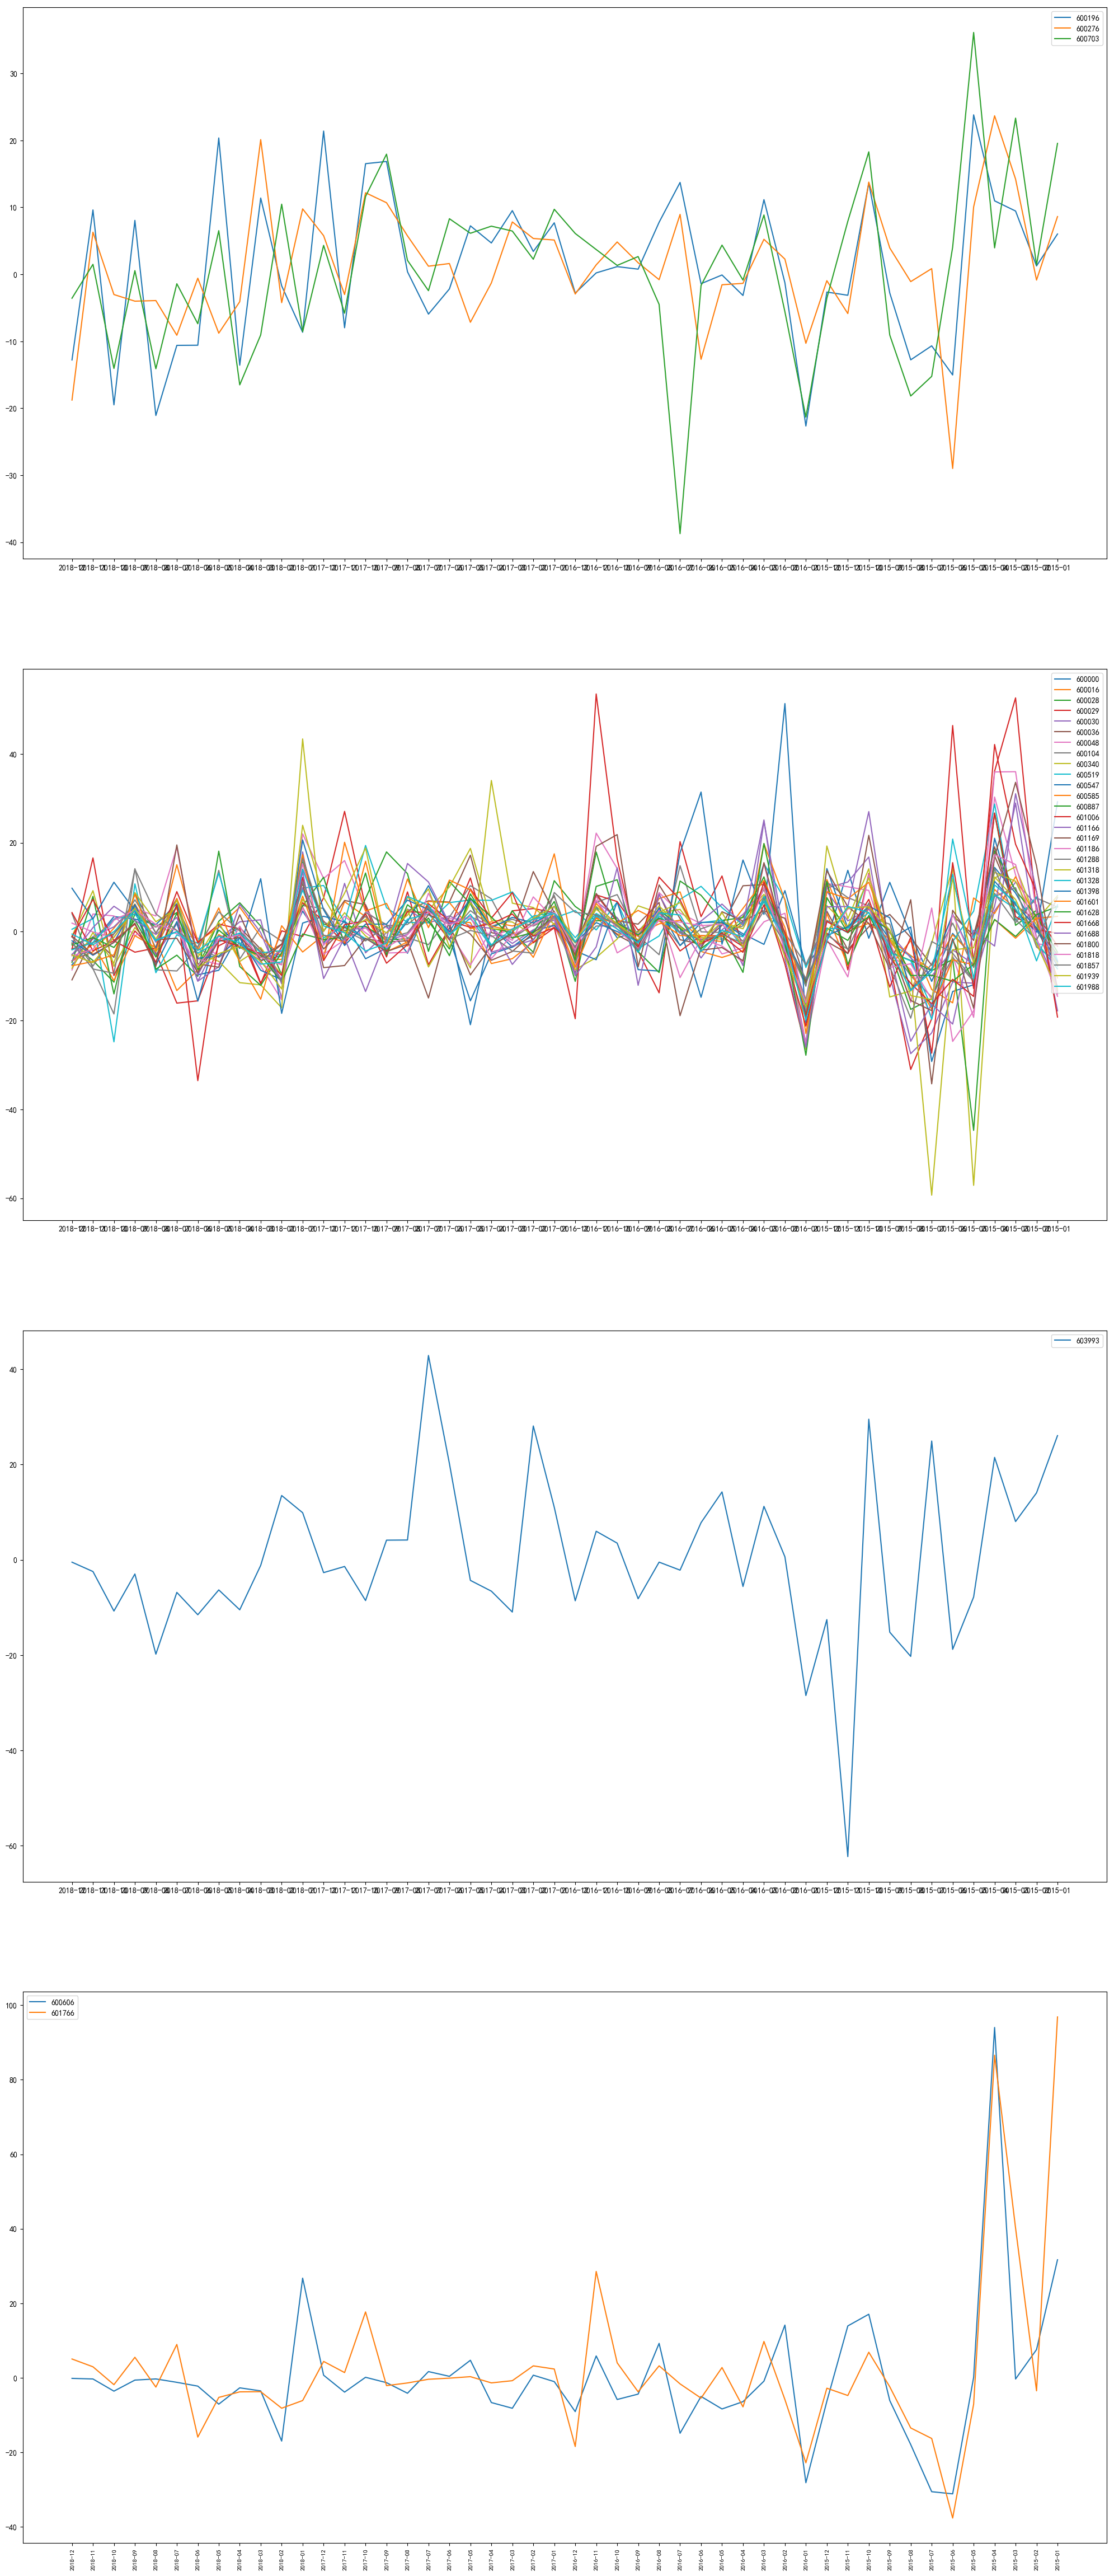

In [30]:
fig, ax = plt.subplots(figsize=(25, 60), nrows=4, ncols=1, dpi=100)
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.xticks(rotation='vertical', fontsize=8)
#plt.gcf().autofmt_xdate()

for i in range(n_labels + 1):
    stocks = np.array(selected_stocks)[model.labels_ == i].tolist()
    for j in stocks:
        ax[i].plot(result.columns, result.loc[j])
        ax[i].legend()


In [31]:
result["labels"] = model.labels_

In [32]:
result

date,2018-12,2018-11,2018-10,2018-09,2018-08,2018-07,2018-06,2018-05,2018-04,2018-03,...,2015-09,2015-08,2015-07,2015-06,2015-05,2015-04,2015-03,2015-02,2015-01,labels
code,,,,,,,,,,,,,,,,,,,,,
600000,-7.47,-2.46,3.39,2.81,1.57,6.27,-9.72,-8.70,-0.34,-6.43,...,11.09,-0.66,-11.20,-0.41,-5.70,14.44,8.67,0.41,-7.78,1
600016,-6.56,-4.54,0.79,6.20,-1.81,-13.27,-8.61,-0.65,-3.38,-5.89,...,-1.74,-5.39,-8.64,-0.70,-5.65,9.48,5.09,-2.53,-12.96,1
600028,-2.71,-6.50,-11.38,4.09,1.03,4.31,-8.07,2.32,6.48,1.25,...,-4.24,-17.50,-15.13,-1.94,-11.21,26.68,1.42,4.81,-7.09,1
600029,-3.94,16.59,-9.91,0.15,-4.79,-16.09,-15.58,-3.19,-0.77,-11.77,...,-7.19,-31.03,-19.59,46.38,-7.79,36.11,52.60,4.01,-3.29,1
600030,-5.10,-1.69,2.82,4.44,-5.22,1.75,-11.15,-1.79,2.21,2.65,...,-9.95,-27.46,-22.80,-11.33,-11.61,4.69,11.14,5.99,-17.82,1
600036,-10.86,-1.25,-5.80,8.48,-0.35,7.42,-8.39,-1.74,0.93,-3.96,...,3.86,-1.33,-7.58,3.65,-0.82,17.02,5.92,2.51,-13.56,1
600048,-8.63,3.97,3.53,-0.90,1.24,-0.49,-1.46,-5.72,-2.60,-7.74,...,-5.34,-8.47,-19.35,-5.46,-19.30,30.29,12.76,-2.77,-3.14,1
600104,4.06,-8.34,-18.54,14.17,-8.59,-8.86,-3.61,13.79,-6.18,1.01,...,-3.17,-9.96,-14.70,-5.80,-11.19,8.61,2.05,7.55,5.50,1
600196,-12.79,9.61,-19.49,8.05,-21.08,-10.61,-10.59,20.36,-13.57,11.39,...,-2.79,-12.77,-10.68,-15.03,23.81,10.97,9.45,1.25,6.02,0
